<h1 style=text-align:center;>Learning from neighbors</h1>

El modelo de este notebook fue desarrollado principalmente en:
- Bala y Goyal (1998) - Learning from Neighbors
- Zollman (2007) - The Communication Structure of Epistemic Communities
- Zollman (2010) - The Epistemic Benefit of Transient Diversity


Otros recursos online para mirar respecto de este modelo:
- [Zollman Effect en Formal Epistemology (SEP)](https://plato.stanford.edu/entries/formal-epistemology/#TheZolEff): una buena descripción del modelo por Jonathan Weisberg.
- [Repo de Formal Epistemology (SEP)](https://github.com/jweisber/sep-sen): implementación de algunos de los modelos de la entrada Formal Epistemology de la SEP hecha por Weisberg.

El modelo consiste en una red de agentes, donde cada agente representa a un científico. En cada turno, los agentes eligen entre dos acciones $A$ y $B$ en base a su creencia sobre qué acción es mejor. En particular, cada agente tiene asociado un número $x \in [0,1]$, representando su creeencia en que la acción $B$ es mejor que la acción $A$.

Los agentes actualizan su creencia $x$ a partir de dos fuentes de información: en primer lugar, observan los *outcomes* de las acciones que eligieron; segundo, también toman en consideración la información recolectada por sus vecinos.

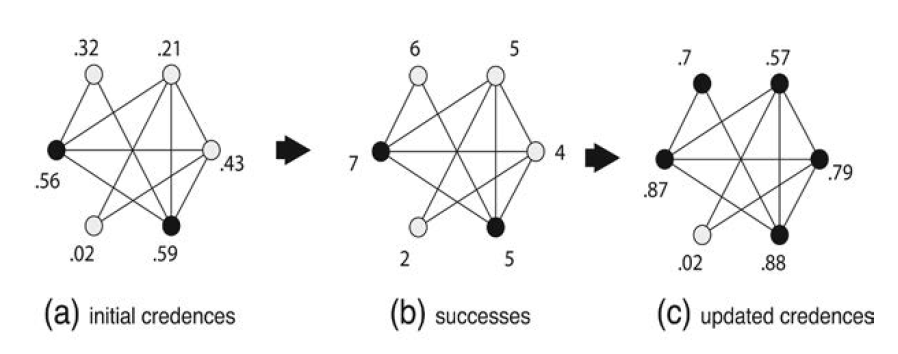

Esta imagen muestra un ejemplo de cómo se ve el proceso.
1. Imagen (a): cada agente tiene una creencia $x \in [0,1]$. Los nodos para los que $x < 0.5$ realizarán la acción $A$ (nodos coloreados de blanco), y los demás realizarán la acción $B$ (nodos negros).
2. Imagen (b): cada agente obtiene un *outcome* en base a la acción que ejecutó.
3. Imagen (c): cada agente actualiza su creencia usando la regla de Bayes sobre la base de los *outcomes* que obtuvo y los *outcomes* obtenidos por sus vecinos.

Dado el agente con creencia $.56$ (que denotaré $a$), puedo establecer lo siguiente:
- $P_a(H) = .56$, y $P_a(H^C) = .44$
- $E = 7$

Además, recuerdo las siguientes reglas:

Probabilidad condicional

$$
P(B|A)= \frac{P(A \cap B)}{P(A)}
$$

Teorema de Bayes:
$$
P(H|E) = \frac{P(E|H)P(H)}{P(E|H)P(H) + P(E|H^C)P(H^C)} = \frac{P(E|H)P(H)}{P(E)}
$$

Update bayesiano en el código de Weisberg:
$$
1 + (1 - P(H))\left( \frac { 0.5 - \epsilon }{ 0.5 + \epsilon } \right) ^{2k - n} / P(H)
$$

donde $n$ es el total de experimentos realizados por un agente y sus vecinos, y $k$ el total de éxitos en esos experimentos.

$$
1 + (1 - P(H))\left( \frac { 1-p }{ p } \right) ^{2k - n} / P(H)
$$

In [1]:
c = 'lala'

In [183]:
def bayes_rule(ph, pch, peh, pech):
    return (peh*ph) / ((peh*ph) + (pech*pch))

In [184]:
bayes_rule(60, 40, 6, 3)

0.75

In [185]:
bayes_rule(15,85,80,20)

0.41379310344827586

In [56]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

En Zollman (2007), se presenta un modelo de base en el que todos los agentes acceden a los resultados de todos los experiemntadores. Ese modelo puede implementarse de la siguiente manera:

In [178]:
epsilon = .01
k = 510
n = 1000
result = ((0.5 - epsilon) / (0.5 + epsilon)) ** (2 * k - n)

In [181]:
(2 * k - n)

20

In [180]:
result

0.44928102674559167

In [177]:
.501 / .499

1.0040080160320641

In [52]:
class Agent:
    def __init__(self, credence):
        self.credence = credence
        
    def bayesian_update(self, p_e_h, p_e_ch):
        self.credence = (p_e_h * self.credence) / ((p_e_h * self.credence) + (p_e_ch * (1-self.credence)))
        
class Simulation:
    def __init__(self, agents):
        self.agents = agents
    
    @property
    def experimenters(self):
        return [agent for agent in self.agents if agent.credence>.5]
    
    @property
    def agent_credences(self):
        return [agent.credence for agent in self.agents]
    
    def step(self):
        for agent in self.agents:
            for experimenter in self.experimenters:
                agent.bayesian_update(p_e_h, p_e_ch)

In [53]:
p_e_h = .4
p_e_ch = .6
credences = [.33, .49, .51, .66]
agents = [Agent(credence) for credence in credences]
sim = Simulation(agents)

sim.step()

In [54]:
sim.agent_credences

[0.17959183673469387,
 0.29923664122137406,
 0.3162790697674419,
 0.5641025641025642]

### Red Watts Strogatz

El modelo [Watts Strogatz](https://es.wikipedia.org/wiki/Modelo_Watts_y_Strogatz) se suele utilizar para construir redes de mundo pequeño. Toma tres parámetros
- $n$: la cantidad de nodos
- $k$: cantidad de vecinos por nodo
- $p$ probabilidad de nuevas conexiones con vecinos lejanos

Cuando $p=0$, la red resultante es una red en anillo con $k$ vecinos para cada nodo.

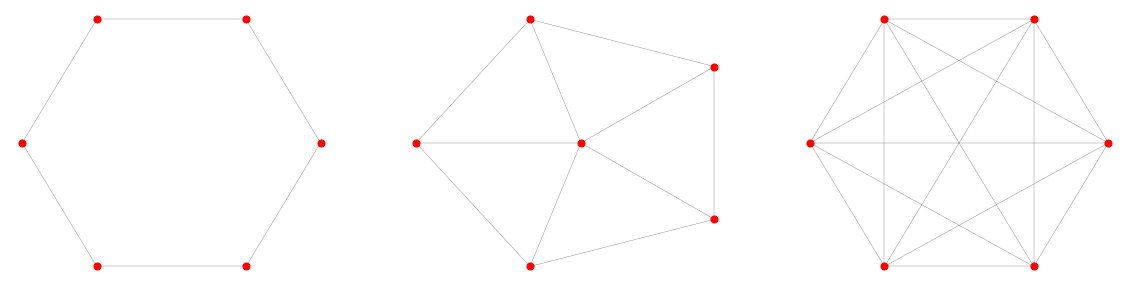

In [82]:
n_players = 6

ring_network = nx.watts_strogatz_graph(n_players, k=2, p=0)
wheel_network = nx.wheel_graph(n_players)
complete_network = nx.complete_graph(n_players)
networks = [ring_network, wheel_network, complete_network]

kwargs = {'width':0.2, 'node_size':50, 'with_labels':False, "node_color":"red"}
fig, ax = plt.subplots(1, 3, figsize=(20,5))
for i, network in enumerate(networks):
    nx.draw_kamada_kawai(network, ax=ax[i], **kwargs)

In [166]:
class Agent:
    def __init__(self, credence, num):
        self.num = num
        self.credence = np.random.uniform(0,1)
        self.n, self.k = 0, 0
        
    @property
    def is_experimenter(self):
        return self.credence > .5
    
    def experiment(self, n):
        self.n = n
        self.k = np.random.binomial(n, p)
            
    def bayesian_update(self, p_e_h, p_e_ch):
        self.credence = (p_e_h * self.credence) / ((p_e_h * self.credence) + (p_e_ch * (1-self.credence)))
        
class Simulation:
    def __init__(self, agents, network):
        self.agents = agents
        self.network = network
        nx.set_node_attributes(self.network, agents, 'player')
        self.round = 0
    
    @property
    def experimenters(self):
        return [agent for agent in self.agents if agent.is_experimenter]
    
    @property
    def agent_credences(self):
        return np.array([agent.credence for agent in self.agents])
    
    def run_experiments(self):
        for experimenter in self.experimenters:
            experimenter.experiment()
    
    def step(self):
        self.run_experiments()
        for agent in self.agents:
            total_n = 0
            total_k = 0
            for neighbor in self.network.neighbors(agent.num):
                total_n += neighbor.n
                total_k += neighbor.k
            agent.bayesian_update()
                
    def go(self):
        while any(self.experimenters) or not all(self.agent_credences==.99):
            self.step()
            self.round += 1
        print(f'Después de {self.round} iteraciones, la simulación terminó.')

In [167]:
n_players = 4
p_e_h = .4
p_e_ch = .6
credences = [.33, .49, .51, .66]
agents = {num:Agent(credence, num) for num,credence in enumerate(credences)}

network = nx.watts_strogatz_graph(n_players, 2, 0)
sim = Simulation(agents, network)

In [176]:
creencias = np.random.uniform(low=0, high=1, size=5)
epsilon = .01
experiment_results = np.random.binomial(1000, .5 + epsilon)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sys
print(sys.path)
sys.path.append('/Users/diegotajer/Desktop/python cositas')
from defcirculo import circulo,rueda,completo
G=nx.Graph()

numeroderondas = 10
nodos = 5
tipodegrafo = rueda

for x in range(nodos):
    G.add_node(x)
    
    
print(tipodegrafo(nodos, G))


nx.draw(G, with_labels=True)
plt.show()

consensos = 0
iteraciones = 100
fracasos = 0
probexito = 0.51

for z in range(iteraciones):
    confianza = {}  
    
      
    
    for x in range(nodos+1):
        confianza[x] = np.random.uniform(0,1)
        
    #print(confianza)
    
    
    
    
    for y in range(numeroderondas):
        ronda = y
        exitosiniciales = {x:0 for x in range(nodos+1)}
        experimentadores = []
        exitostotales = {x:0 for x in range(nodos+1)}
        experimentostotales = {x:0 for x in range(nodos+1)}
        
        
        
        for x in range(nodos+1):
            if confianza[x]>0.5:
                exitosiniciales[x] = np.random.binomial(1000,probexito)
                experimentadores.append(x)
                experimentostotales[x] += 1000
                
        #print(experimentadores)
        
        
        
        
        for x in range(nodos+1):
            exitostotales[x]+=exitosiniciales[x]
        
        for x in range(nodos+1):
            for y in range(nodos+1):
                if (x,y) in G.edges and y in experimentadores:
                    exitostotales[x]+= exitosiniciales[y] 
                    experimentostotales[x]+= 1000
        
        
        #print(experimentostotales)
        #print(exitostotales)
        
        #update bayesiano
        for x in range(nodos+1):
            #update de fracasos
            for y in range(experimentostotales[x]-exitostotales[x]):
                confianza[x] = ((1-probexito) * confianza[x]) / (((1-probexito) * confianza[x]) + (probexito * (1-confianza[x])))
            #update de exitos
            for y in range(exitostotales[x]):
                confianza[x] = (probexito * confianza[x]) / ((probexito * confianza[x]) + ((1-probexito) * (1-confianza[x])))
        
        
        
        #print(confianza)
        
        #ver si se genera el consenso
        believers = 0
        
        for x in range(nodos+1):
            if confianza[x]>0.99:
                believers += 1
                
        if believers == nodos+1:
            consensos += 1
            break
        elif ronda == numeroderondas-1:
            fracasos +=1
            
print('el numero de consensos es '+ str(consensos))
print('el numero de fracasos es '+ str(fracasos))